## ThinkDSP

This notebook contains code examples from Chapter 9: Differentiation and Integration

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [145]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [146]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Difference

As the first example, let's look at the Facebook data again.

In [147]:
if not os.path.exists('FB_2.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB_2.csv

In [148]:
import pandas as pd

df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
len(df)

1977

In [149]:
from thinkdsp import Wave

ys = df['Close']

# for these examples, we need the wave to have 
# an even number of samples
if len(ys) % 2:
    ys = ys[:-1]

close = Wave(ys, framerate=1)
len(close)

1976

Here's what the time series looks like (ignoring the gaps between trading days).

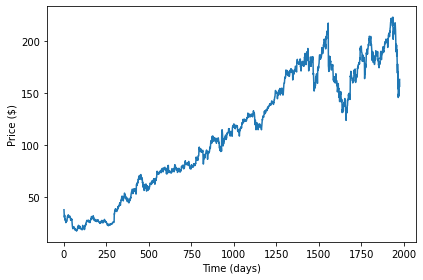

In [150]:
close.plot()
decorate(xlabel='Time (days)', ylabel='Price ($)')

And here's the spectrum on a log-log scale.

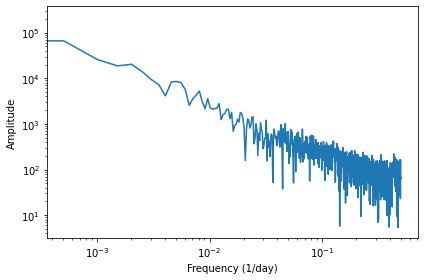

In [151]:
close_spectrum = close.make_spectrum()
close_spectrum.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude',
                 xscale='log', yscale='log')

The slope of the power spectrum is -1.86, which is similar to red noise (which should have a slope of -2).

In [152]:
close_spectrum.estimate_slope().slope

-1.7895322348034641

We can use `np.diff` to compute the difference between successive elements, which is the daily change.

1975

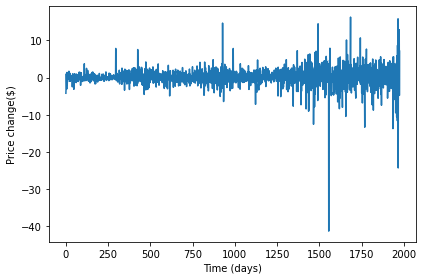

In [153]:
change = Wave(np.diff(close.ys), framerate=1)
change.plot()
decorate(xlabel='Time (days)', ylabel='Price change($)')
len(change)

And here's the spectrum of the daily changes:

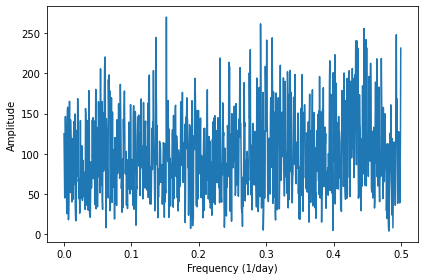

In [154]:
change_spectrum = change.make_spectrum()
change_spectrum.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude')

Recall that the spectrum of white noise looks like white noise.

Here's the spectrum on a log-log scale.

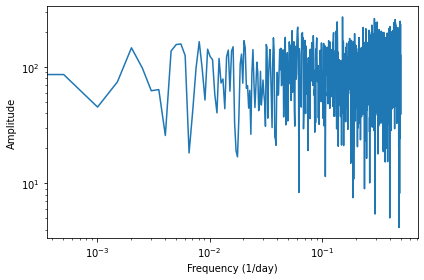

In [155]:
change_spectrum.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude',
                 xscale='log', yscale='log')

The estimated slope is close to zero, which is consistent with white noise.

In [156]:
change_spectrum.estimate_slope().slope

0.09137404305435823

We can think the diff operation as convolution with a difference window, [1, -1].

And convolution with this window corresponds to multiplication by a filter.

The following function computes the filter that corresponds to the window.

In [157]:
from thinkdsp import zero_pad

def make_filter(window, wave):
    """Computes the filter that corresponds to a window.
    
    window: NumPy array
    wave: wave used to choose the length and framerate
    
    returns: new Spectrum
    """
    padded = zero_pad(window, len(wave))
    window_wave = Wave(padded, framerate=wave.framerate)
    window_spectrum = window_wave.make_spectrum()
    return window_spectrum

And here's what the filter looks like for the difference window:

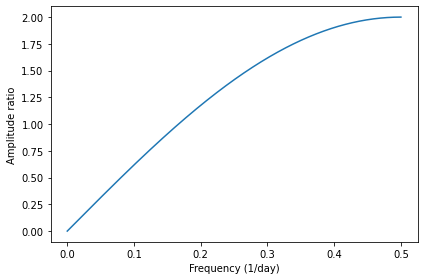

In [158]:
diff_window = np.array([1.0, -1.0])
diff_filter = make_filter(diff_window, close)
diff_filter.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude ratio')

And the angles:

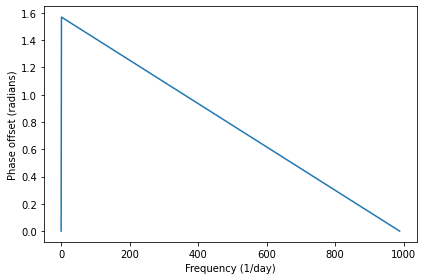

In [159]:
plt.plot(diff_filter.angles)
decorate(xlabel='Frequency (1/day)', ylabel='Phase offset (radians)')

So we could also compute the daily changes by multiplying the spectrum of closing prices by the diff filter:

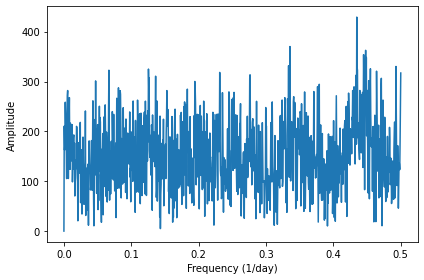

In [160]:
change_spectrum2 = close_spectrum * diff_filter
change_spectrum2.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude')

And then converting the spectrum to a wave.

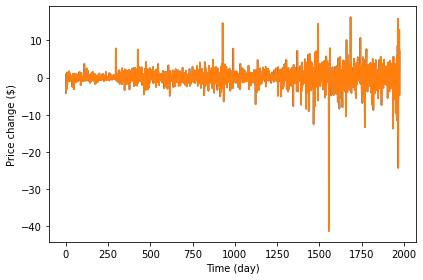

In [161]:
change2 = change_spectrum2.make_wave()

# we have to trim the first element to avoid wrap-around
change2.ys = change2.ys[1:]
change2.ts = change2.ts[1:]

change.plot()
change2.plot()
decorate(xlabel='Time (day)', ylabel='Price change ($)')

Then we can confirm that we get the same result both ways (within floating point error).

In [162]:
change.max_diff(change2)

1.2390088954816747e-13

### Differentiation

This diff operation is an approximation of differentiation, and we can compute the filter for differentiation analytically: each complex component is multiplied by $2 \pi i f$.

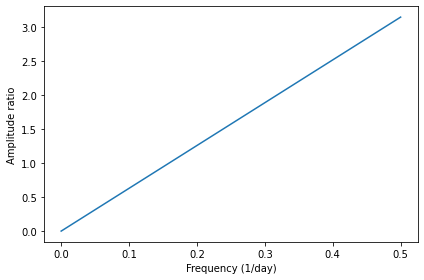

In [163]:
#start with a filter that has the right size, then replace hs

PI2 = np.pi * 2
deriv_filter = close.make_spectrum()
deriv_filter.hs = PI2 * 1j * deriv_filter.fs
deriv_filter.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude ratio')

Now we can apply the derivative filter to the spectrum of closing prices:

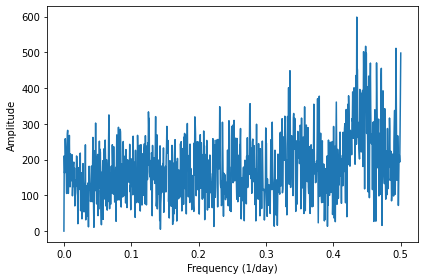

In [164]:
deriv_spectrum = close.make_spectrum().differentiate()

deriv_spectrum.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude')

The results are similar to what we got from `np.diff`, with some differences due to (1) the difference window is only a coarse approximation of the derivative, especially at higher frequencies, and (2) the spectral derivative is based on the assumption that the signal is periodic, so the behavior at the beginning and end is different.

In [165]:
deriv = deriv_spectrum.make_wave()
len(deriv), len(change)

(1976, 1975)

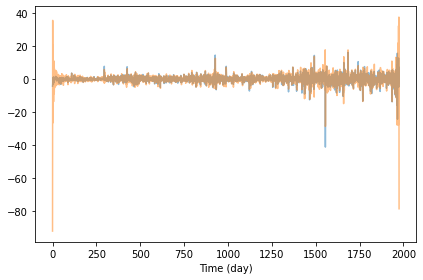

In [166]:
deriv = deriv_spectrum.make_wave()
change.plot(alpha=0.5)
deriv.plot(alpha=0.5)
decorate(xlabel='Time (day)')

We can see the differences more clearly by zooming in on a slice:

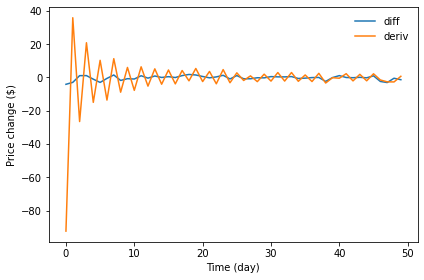

In [167]:
low, high = 0, 50
plt.plot(change.ys[low:high], label='diff')
plt.plot(deriv.ys[low:high], label='deriv')
decorate(xlabel='Time (day)', ylabel='Price change ($)')

The diffs and the spectral derivative are similar in many places, but sometimes substantially different.

Here's the difference between the derivative filter and the difference filter:

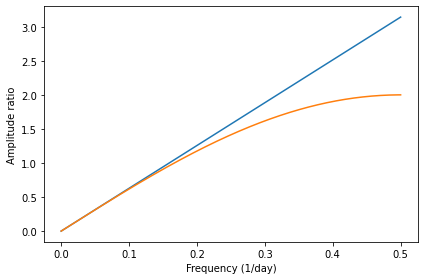

In [168]:
deriv_filter.plot()
diff_filter.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude ratio')

The difference filter does not amplify the highest frequencies as much, which is why the diffs are smoother than the derivative.

## Integration

Now let's think about integration.  We can compute the filter for integration analytically: each frequency component gets divided by $2 \pi i f$.

I plot the result on a log-y scale so we can see it more clearly.

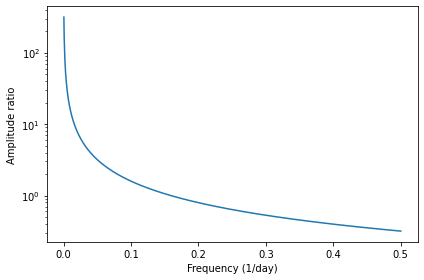

In [169]:
#start with a copy of the deriv filter and replace the hs
integ_filter = deriv_filter.copy()
integ_filter.hs[1:] = 1 / (PI2 * 1j * integ_filter.fs[1:])

# set the component at freq=0 to infinity
integ_filter.hs[0] = np.inf

integ_filter.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude ratio', 
                 yscale='log')

We can confirm that the integration filter is correct by applying it to the spectrum of the derivative we just computed:

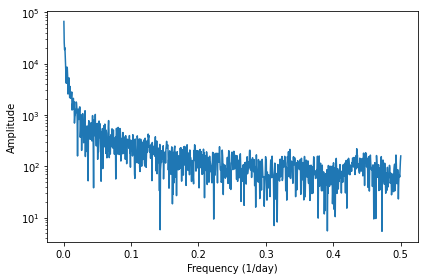

In [170]:
integ_spectrum = deriv_spectrum.copy().integrate()
integ_spectrum.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude')
decorate(yscale='log')

And then converting back to a wave.  The result is identical to the daily closing prices we started with, but shifted so the mean is 0.  

The reason the mean is 0 is that the derivative clobbers the first element of the spectrum, which is the bias.  Once the bias information is lost, integration can't restore it.  So the result has an unspecified constant of integration.

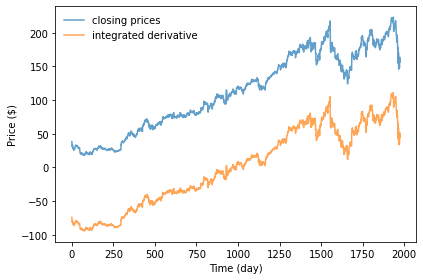

In [171]:
close.plot(label='closing prices', alpha=0.7)

integ_spectrum.hs[0] = 0
integ_wave = integ_spectrum.make_wave()
integ_wave.plot(label='integrated derivative', alpha=0.7)
decorate(xlabel='Time (day)', ylabel='Price ($)')

In [172]:
shift = np.mean(close.ys) - np.mean(integ_wave.ys)

diff = integ_wave.ys - close.ys + shift
np.max(np.abs(diff))

9.947598300641403e-14

### Cumulative sum

In the same way that the diff operator approximates differentiation, the cumulative sum approximates integration.

I'll demonstrate with a Sawtooth signal.

In [173]:
df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
ys = df['Close']

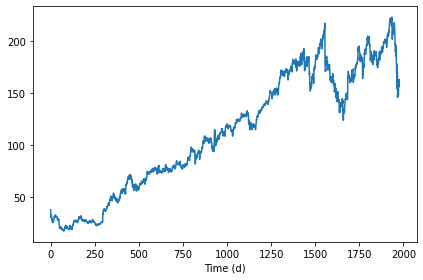

In [174]:
wave = Wave(ys, framerate=1)
wave.plot()
decorate(xlabel='Time (d)')

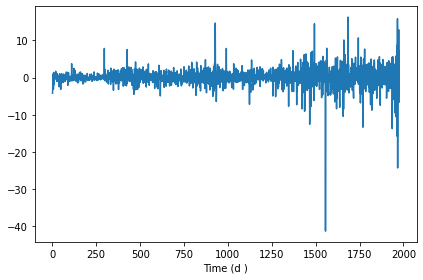

In [175]:
change = wave.diff()
change.plot()
decorate(xlabel='Time (d )')

In [176]:
in_wave = change

Here's the spectrum before the cumulative sum:

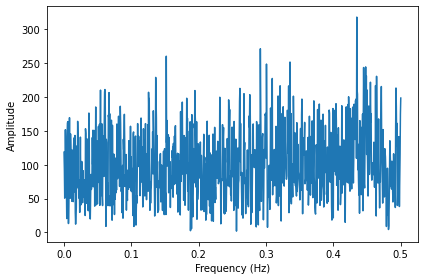

In [177]:
in_spectrum = in_wave.make_spectrum()
in_spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

The output wave is the cumulative sum of the input

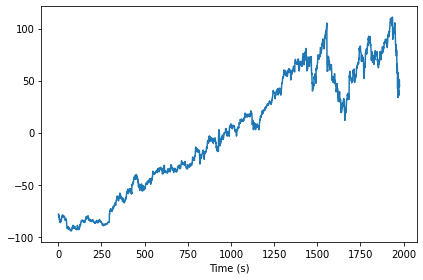

In [178]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel='Time (s)')

And here's its spectrum

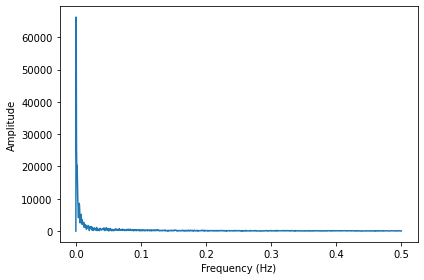

In [179]:
out_spectrum = out_wave.make_spectrum()
out_spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Now we compute the ratio of the output to the input:

In [180]:
sum(in_spectrum.amps < 1), len(in_spectrum)

(0, 989)

In between the harmonics, the input componenents are small, so I set those ratios to NaN.

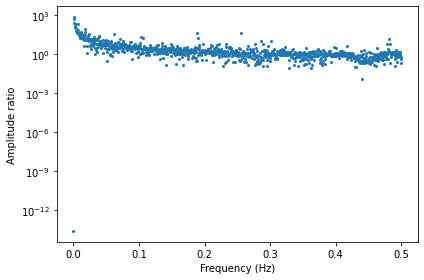

In [181]:
ratio_spectrum = out_spectrum.ratio(in_spectrum, thresh=1)
ratio_spectrum.plot(marker='.', ms=4, ls='')

decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

To get the cumsum filter, I compute the diff filter again and invert it.

In [182]:
# compute the diff filter
diff_window = np.array([1.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()

In [183]:
# compute the cumsum filter by inverting the diff filter
cumsum_filter = diff_filter.copy()
cumsum_filter.hs[1:] = 1 / cumsum_filter.hs[1:]
cumsum_filter.hs[0] = np.inf

In [184]:
# compute the integration filter
integ_filter = cumsum_filter.copy()
integ_filter.hs[1:] = integ_filter.framerate / (PI2 * 1j * integ_filter.fs[1:])
integ_filter.hs[0] = np.inf

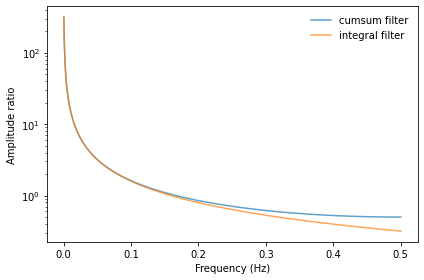

In [185]:
cumsum_filter.plot(label='cumsum filter', alpha=0.7)
integ_filter.plot(label='integral filter', alpha=0.7)

decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

Finally, we can compare the computed ratios to the filter.  They match, confirming that the cumsum filter is the inverse of the diff filter.

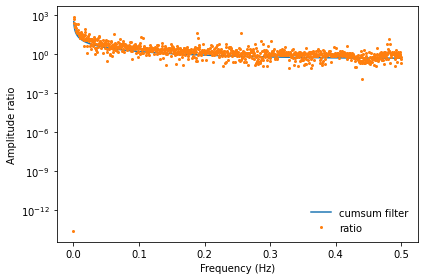

In [186]:
cumsum_filter.plot(label='cumsum filter')
ratio_spectrum.plot(label='ratio', marker='.', ms=4, ls='')
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

Now we can compute the output wave using the convolution theorem, and compare the results:

In [187]:
len(in_spectrum), len(cumsum_filter)

(989, 989)

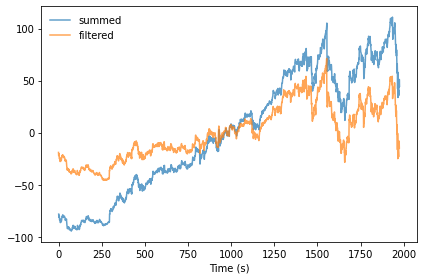

In [188]:
out_wave.plot(label='summed', alpha=0.7)

cumsum_filter.hs[0] = 0
out_wave2 = (in_spectrum * cumsum_filter).make_wave()
out_wave2.plot(label='filtered', alpha=0.7)

decorate(xlabel='Time (s)')

They are the same, within floating point error.

In [189]:
out_wave.max_diff(out_wave2)

59.24999650177148